In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
# from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

### Define device type

In [2]:
# define device type - cuda or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device == torch.device("cuda") else {}

### Load MNIST data

In [3]:
def load_MNIST_data(train_batch_size, test_batch_size, kwargs):
    mnist_transform = transforms.Compose([transforms.ToTensor()])

    mnist_train_data = TVdatasets.MNIST(root='../data', 
                                        train=True,
                                        transform=mnist_transform,
                                        download=True)

    mnist_test_data = TVdatasets.MNIST(root='../data',
                                      train=False,
                                      transform=mnist_transform,
                                      download=True)

    print("Number of train samples:", len(mnist_train_data))
    print("Number of test samples:", len(mnist_test_data))
    
    trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                             batch_size=train_batch_size,
                                             shuffle=True,
                                             **kwargs)

    testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                            batch_size=test_batch_size,
                                            shuffle=False,
                                            **kwargs)
    
    return trainloader, testloader

### Model class

In [4]:
class CNN_net(nn.Module):
    def __init__(self):
        super(CNN_net, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5), # 16*24*24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 32*20*20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 32*10*10
            nn.Conv2d(32,64,5), # 64*6*6
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

### Adversarial Training

In [5]:
def adversarial_training(model, trainloader, attack, num_epochs, stepsize):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=stepsize)

    num_batches = len(trainloader)
    loss_lst = []

    for epoch in range(num_epochs):
        for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            batch_adv_imgs = attack(batch_imgs, batch_labels)

            X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)
            Y_train_gt = torch.cat((batch_labels, batch_labels), 0)
            Y_train_pred = model(X_train)

            loss_val = loss(Y_train_pred, Y_train_gt)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if itr % 100 == 0:
                print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                            itr+1, num_batches, 
                                                                            round(loss_val.item(),4)))

            loss_lst.append(loss_val.item())
    
    plt.figure(figsize=(10,7))
    plt.plot(loss_lst)
    plt.xlabel("iteration")
    plt.ylabel("objective function")
    plt.grid()
    plt.show()

### Load model and data

In [7]:
train_batch_size = 32
test_batch_size = 32

model = CNN_net().to(device)

trainloader, testloader = load_MNIST_data(train_batch_size, test_batch_size, kwargs)

Number of train samples: 60000
Number of test samples: 10000


### Define attack models

In [8]:
adv_eps = 0.3
adv_pgd_steps = 10

fgsm_attack = torchattacks.FGSM(model, eps=adv_eps)
pgd_attack = torchattacks.PGD(model, eps=adv_eps, alpha=0.1, steps=adv_pgd_steps)

### Adversarial Training

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Iteration [1/1875], Loss:2.3288
Epoch [1/5], Iteration [101/1875], Loss:1.2224
Epoch [1/5], Iteration [201/1875], Loss:1.1252
Epoch [1/5], Iteration [301/1875], Loss:0.9417
Epoch [1/5], Iteration [401/1875], Loss:0.7511
Epoch [1/5], Iteration [501/1875], Loss:0.7191
Epoch [1/5], Iteration [601/1875], Loss:0.6991
Epoch [1/5], Iteration [701/1875], Loss:0.5105
Epoch [1/5], Iteration [801/1875], Loss:0.3453
Epoch [1/5], Iteration [901/1875], Loss:0.6475
Epoch [1/5], Iteration [1001/1875], Loss:0.7528
Epoch [1/5], Iteration [1101/1875], Loss:0.2786
Epoch [1/5], Iteration [1201/1875], Loss:0.4488
Epoch [1/5], Iteration [1301/1875], Loss:0.3348
Epoch [1/5], Iteration [1401/1875], Loss:0.1866
Epoch [1/5], Iteration [1501/1875], Loss:0.1951
Epoch [1/5], Iteration [1601/1875], Loss:0.5016
Epoch [1/5], Iteration [1701/1875], Loss:0.2909
Epoch [1/5], Iteration [1801/1875], Loss:0.3825


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Iteration [1/1875], Loss:0.1048
Epoch [2/5], Iteration [101/1875], Loss:0.3929
Epoch [2/5], Iteration [201/1875], Loss:0.133
Epoch [2/5], Iteration [301/1875], Loss:0.0797
Epoch [2/5], Iteration [401/1875], Loss:0.3095
Epoch [2/5], Iteration [501/1875], Loss:0.0804
Epoch [2/5], Iteration [601/1875], Loss:0.0693
Epoch [2/5], Iteration [701/1875], Loss:0.1445
Epoch [2/5], Iteration [801/1875], Loss:0.1677
Epoch [2/5], Iteration [901/1875], Loss:0.4583
Epoch [2/5], Iteration [1001/1875], Loss:0.3331
Epoch [2/5], Iteration [1101/1875], Loss:0.2684
Epoch [2/5], Iteration [1201/1875], Loss:0.3046
Epoch [2/5], Iteration [1301/1875], Loss:0.1536
Epoch [2/5], Iteration [1401/1875], Loss:0.187
Epoch [2/5], Iteration [1501/1875], Loss:0.2006
Epoch [2/5], Iteration [1601/1875], Loss:0.0768
Epoch [2/5], Iteration [1701/1875], Loss:0.3892
Epoch [2/5], Iteration [1801/1875], Loss:0.1489


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Iteration [1/1875], Loss:0.102
Epoch [3/5], Iteration [101/1875], Loss:0.1318
Epoch [3/5], Iteration [201/1875], Loss:0.066
Epoch [3/5], Iteration [301/1875], Loss:0.1247
Epoch [3/5], Iteration [401/1875], Loss:0.1177
Epoch [3/5], Iteration [501/1875], Loss:0.0989
Epoch [3/5], Iteration [601/1875], Loss:0.0718
Epoch [3/5], Iteration [701/1875], Loss:0.112
Epoch [3/5], Iteration [801/1875], Loss:0.2145
Epoch [3/5], Iteration [901/1875], Loss:0.1251
Epoch [3/5], Iteration [1001/1875], Loss:0.0959
Epoch [3/5], Iteration [1101/1875], Loss:0.0996
Epoch [3/5], Iteration [1201/1875], Loss:0.0647
Epoch [3/5], Iteration [1301/1875], Loss:0.0316
Epoch [3/5], Iteration [1401/1875], Loss:0.1397
Epoch [3/5], Iteration [1501/1875], Loss:0.1215
Epoch [3/5], Iteration [1601/1875], Loss:0.1059
Epoch [3/5], Iteration [1701/1875], Loss:0.0922
Epoch [3/5], Iteration [1801/1875], Loss:0.0628


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Iteration [1/1875], Loss:0.0827
Epoch [4/5], Iteration [101/1875], Loss:0.2439
Epoch [4/5], Iteration [201/1875], Loss:0.0636
Epoch [4/5], Iteration [301/1875], Loss:0.1326
Epoch [4/5], Iteration [401/1875], Loss:0.0816
Epoch [4/5], Iteration [501/1875], Loss:0.2276
Epoch [4/5], Iteration [601/1875], Loss:0.0389
Epoch [4/5], Iteration [701/1875], Loss:0.0444
Epoch [4/5], Iteration [801/1875], Loss:0.0292
Epoch [4/5], Iteration [901/1875], Loss:0.0386
Epoch [4/5], Iteration [1001/1875], Loss:0.0697
Epoch [4/5], Iteration [1101/1875], Loss:0.0637
Epoch [4/5], Iteration [1201/1875], Loss:0.0374
Epoch [4/5], Iteration [1301/1875], Loss:0.1972
Epoch [4/5], Iteration [1401/1875], Loss:0.1451
Epoch [4/5], Iteration [1501/1875], Loss:0.051
Epoch [4/5], Iteration [1601/1875], Loss:0.0498
Epoch [4/5], Iteration [1701/1875], Loss:0.0162
Epoch [4/5], Iteration [1801/1875], Loss:0.0788


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Iteration [1/1875], Loss:0.0371
Epoch [5/5], Iteration [101/1875], Loss:0.076
Epoch [5/5], Iteration [201/1875], Loss:0.1078
Epoch [5/5], Iteration [301/1875], Loss:0.2293
Epoch [5/5], Iteration [401/1875], Loss:0.0932
Epoch [5/5], Iteration [501/1875], Loss:0.0878
Epoch [5/5], Iteration [601/1875], Loss:0.3822
Epoch [5/5], Iteration [701/1875], Loss:0.0146
Epoch [5/5], Iteration [801/1875], Loss:0.0812
Epoch [5/5], Iteration [901/1875], Loss:0.1149
Epoch [5/5], Iteration [1001/1875], Loss:0.0835
Epoch [5/5], Iteration [1101/1875], Loss:0.1711
Epoch [5/5], Iteration [1201/1875], Loss:0.1416
Epoch [5/5], Iteration [1301/1875], Loss:0.0306
Epoch [5/5], Iteration [1401/1875], Loss:0.2138
Epoch [5/5], Iteration [1501/1875], Loss:0.082
Epoch [5/5], Iteration [1601/1875], Loss:0.0239
Epoch [5/5], Iteration [1701/1875], Loss:0.0235
Epoch [5/5], Iteration [1801/1875], Loss:0.0034


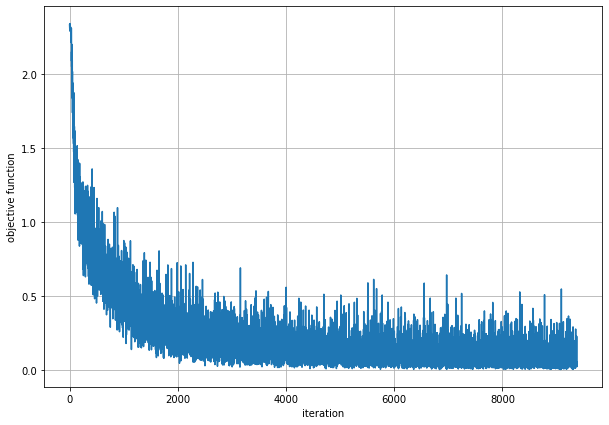

In [9]:
adversarial_training(model, trainloader, pgd_attack, num_epochs=5, stepsize=1e-3)

### Test accuracy (standard clean)

In [13]:
num_samples = 0
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        X_test = batch_imgs.to(device)
        Y_test_gt = batch_labels.to(device)

        _, Y_test_pred = torch.max(model(X_test), dim=1)
    #     print(Y_test_gt.shape, Y_test_pred.shape)

        num_samples += batch_imgs.shape[0]
        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 99.21 %


### Test accuracy (PGD attack)

In [11]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test = pgd_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 95.08 %


### Test accuracy (FGSM attack)

In [12]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_test = fgsm_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 96.8 %


### Test accuracy (FGSM + PGD - attack)

In [14]:
num_samples = 0
num_corr_pred = 0
model.eval()

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += Y_test_gt.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 95.96 %
